In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

## Setup for Notebook

In [2]:
validation_gams = "../data/validation_data/gams"
validation_julia = "../data/validation_data/julia"
segnames = pd.read_csv("../data/subsets/random10.csv", header = None)

segnames

,0
0,Portugal214
1,Thailand2067
2,SaudiArabia1469
3,Philippines11144
4,UnitedStates5254
5,UnitedStates3687
6,FrenchPolynesia6421
7,Norway9157
8,Philippines10789
9,India1815


## 1a. Save a Subset of the GAMS Data (Run Once)

Note here we will use the RCP8.5 baseline results from Diaz 2016

### Get Files

In [3]:
# need all the gams data locally
dir_gams = "/Users/lisarennels/JuliaProjects/CIAMPaper/local-data/gams-outputs/gams-results"

# get file names
files_rcp85 = ["rcp85p50ref"+str(k)+".csv" for k in range(1,11)]

# read all files and place in a list of Pandas dataframes
dfG_all = []
for file in files_rcp85:
    dfG_all.append(pd.read_csv(dir_gams+"/rcp85/"+file))

# concatenate all into a master file. don't worry about the times being out of order; the 
# calculations will specify the year and type of damages to be summed up later
dfG = pd.concat(dfG_all)

dfG

,time,segments,level,variable,value
0,1,Canada5106,1.0,FloodRetreat,0.000144
1,1,Canada5106,1.0,RetreatCost,0.000144
2,2,Canada5106,1.0,FloodRetreat,0.000144
3,2,Canada5106,1.0,RetreatCost,0.000144
4,3,Canada5106,1.0,FloodRetreat,0.000144
...,...,...,...,...,...
2074982,20,Peru3963,NaN,FloodOptimalFixed,0.003227
2074983,20,Peru3963,NaN,RelocateOptimalFixed,0.000024
2074984,20,Peru3963,NaN,StormCapitalOptimalFixed,0.002491
2074985,20,Peru3963,NaN,StormPopOptimalFixed,0.003235


### Filter for just the subset of segments we are going to use

In [4]:
dfSubset = dfG.loc[dfG["segments"].isin(segnames[0])]
dfSubset

,time,segments,level,variable,value
14317,1,Norway9157,1.0,FloodRetreat,0.000026
14318,1,Norway9157,1.0,RetreatCost,0.000026
14319,2,Norway9157,1.0,FloodRetreat,0.000026
14320,2,Norway9157,1.0,RetreatCost,0.000026
14321,3,Norway9157,1.0,FloodRetreat,0.000026
...,...,...,...,...,...
1875900,18,FrenchPolynesia6421,NaN,OptimalFixedCost,0.001224
1875901,19,FrenchPolynesia6421,NaN,FloodOptimalFixed,0.001383
1875902,19,FrenchPolynesia6421,NaN,OptimalFixedCost,0.001383
1875903,20,FrenchPolynesia6421,NaN,FloodOptimalFixed,0.001383


In [5]:
dfSubset.to_csv(validation_gams + "rcp85p50ref_random10.csv",  index=False)

### Cleanup

In [6]:
del dfSubset, dfG, dfG_all

## 1b. Load and Clean GAMS Data

Note here we will use the RCP8.5 baseline results from Diaz 2016

### Load Data

In [7]:
dfG = pd.read_csv(validation_gams + "rcp85p50ref_random10.csv")
dfG

,time,segments,level,variable,value
0,1,Norway9157,1.0,FloodRetreat,0.000026
1,1,Norway9157,1.0,RetreatCost,0.000026
2,2,Norway9157,1.0,FloodRetreat,0.000026
3,2,Norway9157,1.0,RetreatCost,0.000026
4,3,Norway9157,1.0,FloodRetreat,0.000026
...,...,...,...,...,...
8791,18,FrenchPolynesia6421,NaN,OptimalFixedCost,0.001224
8792,19,FrenchPolynesia6421,NaN,FloodOptimalFixed,0.001383
8793,19,FrenchPolynesia6421,NaN,OptimalFixedCost,0.001383
8794,20,FrenchPolynesia6421,NaN,FloodOptimalFixed,0.001383


### Fix the segment names with apostrophes in them

In [8]:
for seg in dfG.segments.unique():
    if '\'' in seg:
        new_name = seg.replace('\'', '') 
        dfG.loc[(dfG.segments==seg), "segments"] = new_name

### Gather up Diaz 2016 results into a DataFrame

In [9]:
NoAdaptCost, OptimalCost, FloodNoAdapt, WetlandNoAdapt, RelocateNoAdapt, StormCapitalNoAdapt, StormPopNoAdapt, WetlandRetreat, WetlandProtect = [], [], [], [], [], [], [], [], []
Construct10, ProtectCost10, StormPopProtect10, StormCapitalProtect10 = [], [], [], []
Construct10000, ProtectCost10000, StormPopProtect10000, StormCapitalProtect10000 = [], [], [], []
RetreatCost10, StormPopRetreat10, StormCapitalRetreat10, RelocateRetreat10 = [], [], [], []
RetreatCost10000, StormPopRetreat10000, StormCapitalRetreat10000, RelocateRetreat10000 = [], [], [], []
for t in range(1,11):
    NoAdaptCost.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="NoAdaptCost"), "value"].sum())
    OptimalCost.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="OptimalFixedCost"), "value"].sum())
    FloodNoAdapt.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="FloodNoAdapt"), "value"].sum())
    WetlandNoAdapt.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="WetlandNoAdapt"), "value"].sum())
    RelocateNoAdapt.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="RelocateNoAdapt"), "value"].sum())
    StormCapitalNoAdapt.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="StormCapitalNoAdapt"), "value"].sum())
    StormPopNoAdapt.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="StormPopNoAdapt"), "value"].sum())
    WetlandRetreat.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="WetlandRetreat"), "value"].sum())
    WetlandProtect.append(dfG.loc[(dfG["time"]==t) & (dfG["variable"]=="WetlandProtect"), "value"].sum())
    Construct10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="ConstructOptimalFixed"), "value"].sum())
    ProtectCost10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="ProtectCost"), "value"].sum())
    StormPopProtect10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="StormPopProtect"), "value"].sum())
    StormCapitalProtect10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="StormCapitalProtect"), "value"].sum())
    RetreatCost10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="RetreatCost"), "value"].sum())
    StormPopRetreat10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="StormPopRetreat"), "value"].sum())
    StormCapitalRetreat10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="StormCapitalRetreat"), "value"].sum())
    RelocateRetreat10.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10) & (dfG["variable"]=="RelocateRetreat"), "value"].sum())
    Construct10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="ConstructOptimalFixed"), "value"].sum())
    ProtectCost10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="ProtectCost"), "value"].sum())
    StormPopProtect10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="StormPopProtect"), "value"].sum())
    StormCapitalProtect10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["level"]==10000) & (dfG["variable"]=="StormCapitalProtect"), "value"].sum())
    RetreatCost10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="RetreatCost"), "value"].sum())
    StormPopRetreat10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="StormPopRetreat"), "value"].sum())
    StormCapitalRetreat10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="StormCapitalRetreat"), "value"].sum())
    RelocateRetreat10000.append(dfG.loc[(dfG["time"]==t) & (dfG["level"]==10000) & (dfG["variable"]=="RelocateRetreat"), "value"].sum())

dfDiaz = pd.DataFrame()
dfDiaz["time"] = list(range(2010,2110,10))
dfDiaz["NoAdapt"] = NoAdaptCost
dfDiaz["Optimal"] = OptimalCost
dfDiaz["FloodNoAdapt"] = FloodNoAdapt
dfDiaz["WetlandNoAdapt"] = WetlandNoAdapt
dfDiaz["RelocateNoAdapt"] = RelocateNoAdapt
dfDiaz["StormCapitalNoAdapt"] = StormCapitalNoAdapt
dfDiaz["StormPopNoAdapt"] = StormPopNoAdapt
dfDiaz["WetlandProtect"] = WetlandProtect
#dfDiaz["Construct"] = Construct
dfDiaz["WetlandRetreat"] = WetlandRetreat
dfDiaz["ProtectCost10"] = ProtectCost10
dfDiaz["StormPopProtect10"] = StormPopProtect10
dfDiaz["StormCapitalProtect10"] = StormCapitalProtect10
dfDiaz["RetreatCost10"] = RetreatCost10
dfDiaz["StormPopRetreat10"] = StormPopRetreat10
dfDiaz["StormCapitalRetreat10"] = StormCapitalRetreat10
dfDiaz["RelocateRetreat10"] = RelocateRetreat10
dfDiaz["ProtectCost10000"] = ProtectCost10000
dfDiaz["StormPopProtect10000"] = StormPopProtect10000
dfDiaz["StormCapitalProtect10000"] = StormCapitalProtect10000
dfDiaz["RetreatCost10000"] = RetreatCost10000
dfDiaz["StormPopRetreat10000"] = StormPopRetreat10000
dfDiaz["StormCapitalRetreat10000"] = StormCapitalRetreat10000
dfDiaz["RelocateRetreat10000"] = RelocateRetreat10000

## 2. Load Julia Data

### Load Data

In [10]:
dfC = pd.read_csv(validation_julia + "/ctrl+noConstrFix_global_85p50ssp0fixed.csv")
dfN = pd.read_csv(validation_julia + "/ctrl+noConstrFix_seg_85p50ssp0fixed.csv")
dfO = pd.read_csv(validation_julia + "/ctrl+noConstrFix_seg_85p50ssp0fixed_optimal.csv") # optimal actions for each segment

In [11]:
dfC1 = dfC.copy() # copies so that the new, shorter-foresight model version can be compared to old perfect foresight version
dfN1 = dfN.copy()
dfO1 = dfO.copy()

### NPV foresight correction

This correction accounts for the fact that the new version of CIAM considers NPV over the current adaptation period (40-50 years generally), whereas the previous GAMS version assumes NPV is known across the entire model time horizon (2000-2100, for example).

#### discount factor 

Matches output from a run model in Julia `m[:slrcost, :discountfactor]`

`v.discountfactor[TimestepIndex(i)] = 1/(1 + p.discountrate)^(p.tstep * (i-1))`

In [12]:
drate = 0.04
tstep = 10
discountfactor = 1/(1+drate)**(tstep*np.arange(0,20,1))
print(discountfactor)

[1.00000000e+00 6.75564169e-01 4.56386946e-01 3.08318668e-01
 2.08289045e-01 1.40712615e-01 9.50604010e-02 6.42194008e-02
 4.33843261e-02 2.93088962e-02 1.98000401e-02 1.33761976e-02
 9.03647984e-03 6.10472199e-03 4.12413144e-03 2.78611543e-03
 1.88219975e-03 1.27154671e-03 8.59011398e-04 5.80317321e-04]


#### segments

In [13]:
segments_G, segments_N = {}, {}
for t in range(1,21):
    segments_G[t] = list(dfG.loc[(dfG.time==t), "segments"].unique())
    segments_N[t] = list(dfN.loc[(dfN.time==t), "segments"].unique())
segments_G["all"] = list(dfG.segments.unique())
segments_N["all"] = list(dfN.segments.unique())

Need to do the first time step separately. it is special because in the "fixed" mode a la original (GAMS) CIAM, this is where the adaptation strategy is determined. This strategy (including level) will be followed throughout the time horizon.

In [14]:
tol= 0.0001
levs = {"RetreatCost" : [1,10,100,1000,10000], "ProtectCost" : [10,100,1000,10000], "NoAdaptCost" : [0]}
options = []
for var in ["RetreatCost","ProtectCost"]:
    for lev in levs[var]:
            options.append(var+str(lev))
options.append("NoAdaptCost0")

#### find which segments have a mismatch; otherwise, this fix won't do anything since there's no change to the segment

In [15]:
actions_G = {}
dfGsub = dfG.loc[(dfG.time==1) & (dfG.variable.isin(["OptimalFixedCost","NoAdaptCost","ProtectCost","RetreatCost"]))]
for seg in dfGsub.loc[(dfGsub.time==1)&(dfGsub.variable=="OptimalFixedCost"), "segments"].unique():
    cost = float(dfGsub.loc[(dfGsub.time==1) & (dfGsub.segments==seg) & (dfGsub.variable=="OptimalFixedCost"), "value"])
    level_action = dfGsub.loc[(dfGsub.time==1) & (dfGsub.segments==seg) & 
                              (dfGsub.value==cost) & (dfGsub.variable!="OptimalFixedCost"),["level","variable"]]
    if level_action["variable"].iloc[0]=="NoAdaptCost":
        actions_G[seg] = level_action["variable"].iloc[0]+"0"
    else:
        actions_G[seg] = level_action["variable"].iloc[0]+str(int(level_action["level"].iloc[0]))
        
actions_N = {}
dfNsub = dfN.loc[(dfN.time==1) & (dfN.variable.isin(["OptimalCost","NoAdaptCost","ProtectCost","RetreatCost"]))]
for seg in dfNsub.loc[(dfNsub.time==1)&(dfNsub.variable=="OptimalCost"), "segments"].unique():
    cost = float(dfNsub.loc[(dfNsub.time==1) & (dfNsub.segments==seg) & (dfNsub.variable=="OptimalCost"), "value"])
    level_action = dfNsub.loc[(dfNsub.time==1) & (dfNsub.segments==seg) & 
                              (dfNsub.value==cost) & (dfNsub.variable!="OptimalCost"),["level","variable"]]
    if level_action["variable"].iloc[0]=="NoAdaptCost":
        actions_N[seg] = level_action["variable"].iloc[0]+"0"
    else:
        actions_N[seg] = level_action["variable"].iloc[0]+str(int(level_action["level"].iloc[0]))
        
mismatches = {}
for seg in actions_G.keys():
    if actions_G[seg]!=actions_N[seg]:
        mismatches[seg] = (actions_G[seg],actions_N[seg])

Compute the NPV using the full time horizon for decision-making (entire simulation period), instead of the new version's shorter time horizon (40-50 years).

In [16]:
import time

In [17]:
tbeg = time.time()

new_costs, new_NPV = [0]*len(mismatches), [0]*len(mismatches)
new_choices = [0]*len(mismatches)
old_costs = [0]*len(mismatches)

# dict keys don't have fixed order, so save as a list
mismatch_segments = list(mismatches.keys())

# subset to only segments we need
dfNsub = dfN.loc[(dfN.segments.isin(mismatch_segments))]
dfOsub = dfO.loc[(dfO.segments.isin(mismatch_segments))]
dfGsub = dfG.loc[(dfG.segments.isin(mismatch_segments))]

for seg in mismatch_segments:
    s = mismatch_segments.index(seg)

    t=1 # needs to be reset each segment
    option_costs = []
    for var in ["RetreatCost","ProtectCost","NoAdaptCost"]:
        for lev in levs[var]:
            if var != "NoAdaptCost":
                NPV = dfNsub.loc[(dfNsub.variable==var) & (dfNsub.segments==seg) & 
                                 (dfNsub.level==lev), "value"]*discountfactor
            else:
                NPV = dfNsub.loc[(dfNsub.variable==var) & (dfNsub.segments==seg),"value"]*discountfactor
            option_costs.append(np.sum(NPV))
    new_NPV[s] = min(option_costs)
    new_choices[s] = options[option_costs.index(new_NPV[s])]
    # get the new optimal costs in this time step
    var = new_choices[s][:7]+"Cost"  # RetreatCost, ProtectCost, NoAdaptCost
    lev = int(re.findall(r'\d+', new_choices[s])[0])
    if var != "NoAdaptCost":
        new_costs[s] = float(dfNsub.loc[(dfNsub.segments==seg) & (dfNsub.time==t) & 
                                        (dfNsub.variable==var) & (dfNsub.level==lev), "value"])
    else:
        new_costs[s] = float(dfNsub.loc[(dfNsub.segments==seg) & (dfNsub.time==t) & 
                                        (dfNsub.variable==var), "value"])
    old_costs[s] = float(dfOsub.loc[(dfOsub.segments==seg) & (dfOsub.time==t), "OptimalCost"])

    # correct the results dataframes to match the GAMS version's perfect foresight
    dfO.loc[(dfO.segments==seg),"variable"] = var  # these are assuming fixed mode
    dfO.loc[(dfO.segments==seg),"level"] = lev
    dfO.loc[(dfO.segments==seg) & (dfO.time==t),"OptimalCost"] = new_costs[s]
    dfN.loc[(dfN.segments==seg) & (dfN.time==t) & (dfN.variable=="OptimalCost"), "value"] = new_costs[s]
    dfC.loc[(dfC.time==t) & (dfC.variable=="OptimalCost"), "value"] = dfC.loc[(dfC.time==t) & (dfC.variable=="OptimalCost"), "value"] - \
                                                                      old_costs[s] + new_costs[s]
    # In subsequent years, the choice and level stay the same. So, just need to correct things in dfO, dfN, and dfC. 
    # Retain the other versions of these dataframes from above to compare how the perfect foresight leads to an overestimation of costs.
    for t in dfC.time.unique()[1:]:
        if var!="NoAdaptCost":
            optcost = float(dfNsub.loc[(dfNsub.segments==seg) & (dfNsub.time==t) & 
                                       (dfNsub.variable==var) & (dfNsub.level==lev), "value"])
        else:
            optcost = float(dfNsub.loc[(dfNsub.segments==seg) & (dfNsub.time==t) & 
                                       (dfNsub.variable==var), "value"])
        old_optcost = float(dfNsub.loc[(dfNsub.segments==seg) & (dfNsub.time==t) & (dfNsub.variable=="OptimalCost"), "value"])
        dfN.loc[(dfN.segments==seg) & (dfN.time==t) & (dfN.variable=="OptimalCost"), "value"] = optcost
        dfO.loc[(dfO.segments==seg) & (dfO.time==t), "OptimalCost"] = optcost
        dfC.loc[(dfC.time==t) & (dfC.variable=="OptimalCost"), "value"] += optcost - old_optcost
        
tend = time.time()
print((tend-tbeg)/60)

0.0030156811078389484


## 3. Make Comparisons

### 3a. Define Functions

define a function to process a pair of results DataFrames (need optimal costs/actions one, the total costs one, and the subcosts one) into the form needed to make the bar chart decomposition of costs (below). Assumes `fixed=true`

In [18]:
def process_costs_df(dfC, dfO, dfN, tmax=False):
    # set up
    ntime = len(dfO.time.unique())
    levs = {"RetreatCost" : [1,10,100,1000,10000], "ProtectCost" : [10,100,1000,10000], "NoAdaptCost" : [0]}
    
    # figure out which segments pursue which adaptation options, and at what levels of protection
    actions = {}
    for choice in levs.keys():
        for lev in levs[choice]:
            if lev > 0:
                actions[choice+str(lev)] = list(dfO.loc[(dfO.time==1)&(dfO.variable==choice)&(dfO.level==lev),"segments"])
            else:
                actions[choice+str(lev)] = list(dfO.loc[(dfO.time==1)&(dfO.variable==choice),"segments"])
    retreat_segs, protect_segs = [], []
    for lev in levs["RetreatCost"]:
        retreat_segs += actions["RetreatCost"+str(lev)]
    for lev in levs["ProtectCost"]:
        protect_segs += actions["ProtectCost"+str(lev)]
        
    # tally up costs associated with each action
    retreat_costs_N = [0]*ntime
    protect_costs_N = [0]*ntime
    inundation_costs_N = [0]*ntime
    wetland_costs_N = [0]*ntime
    flood_costs_N = [0]*ntime
    
    for t in range(1,ntime+1):
        dfNsub = dfN.loc[(dfN.time==t)] # subset to speed the loop up
        # retreat
        for lev in levs["RetreatCost"]:
            pname = "RetreatCost"+str(lev)
            retreat_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.variable=="RelocateRetreat") & (dfNsub.level==lev), "value"].sum()
        retreat_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions["NoAdaptCost0"])) & (dfNsub.variable=="RelocateNoAdapt"), "value"].sum()
        # protect
        for lev in levs["ProtectCost"]:
            pname = "ProtectCost"+str(lev)
            protect_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.variable=="Construct") & (dfNsub.level==lev), "value"].sum()
        # inundation (Flood)
        for lev in levs["RetreatCost"]:
            pname = "RetreatCost"+str(lev)
            inundation_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.variable=="FloodRetreat") & (dfNsub.level==lev), "value"].sum()
        inundation_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions["NoAdaptCost0"])) & (dfNsub.variable=="FloodNoAdapt"), "value"].sum()
        # wetland
        for lev in levs["RetreatCost"]:
            pname = "RetreatCost"+str(lev)
            wetland_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.variable=="WetlandRetreat"), "value"].sum()
        for lev in levs["ProtectCost"]:
            pname = "ProtectCost"+str(lev)
            wetland_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.variable=="WetlandProtect"), "value"].sum()
        wetland_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions["NoAdaptCost0"])) & (dfNsub.variable=="WetlandNoAdapt"), "value"].sum()
        # flooding (Storm)
        for lev in levs["RetreatCost"]:
            pname = "RetreatCost"+str(lev)
            flood_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.level==lev) & (dfNsub.variable.isin(["StormCapitalRetreat","StormPopRetreat"])), "value"].sum()
        for lev in levs["ProtectCost"]:
            pname = "ProtectCost"+str(lev)
            flood_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions[pname])) & (dfNsub.level==lev) & (dfNsub.variable.isin(["StormCapitalProtect","StormPopProtect"])), "value"].sum()
        flood_costs_N[t-1] += dfNsub.loc[(dfNsub.segments.isin(actions["NoAdaptCost0"])) & (dfNsub.variable.isin(["StormCapitalNoAdapt","StormPopNoAdapt"])), "value"].sum()

    if not tmax:
        tmax = ntime
        
    dfNew = pd.DataFrame()
    dfNew["time"] = list(range(1,ntime+1))
    dfNew["NoAdapt"] = list(dfC.loc[(dfC.variable=="NoAdaptCost"), "value"])
    dfNew["Optimal"] = list(dfC.loc[(dfC.variable=="OptimalCost"), "value"])
    dfNew["FloodNoAdapt"] = list(dfC.loc[(dfC.variable=="FloodNoAdapt"), "value"])
    dfNew["WetlandNoAdapt"] = list(dfC.loc[(dfC.variable=="WetlandNoAdapt"), "value"])
    dfNew["RelocateNoAdapt"] = list(dfC.loc[(dfC.variable=="RelocateNoAdapt"), "value"])
    dfNew["StormCapitalNoAdapt"] = list(dfC.loc[(dfC.variable=="StormCapitalNoAdapt"), "value"])
    dfNew["StormPopNoAdapt"] = list(dfC.loc[(dfC.variable=="StormPopNoAdapt"), "value"])
    dfNew["RetreatOptimal"] = retreat_costs_N
    dfNew["ProtectOptimal"] = protect_costs_N
    dfNew["InundationOptimal"] = inundation_costs_N
    dfNew["WetlandOptimal"] = wetland_costs_N
    dfNew["FloodOptimal"] = flood_costs_N
    dfNew = dfNew.loc[(dfNew.time <= tmax)]
    
    return dfNew

In [19]:
# baseline result - matching to GAMS CIAM, both with perfect foresight
dfNew0 = process_costs_df(dfC=dfC, dfO=dfO, dfN=dfN, tmax=10)
dfNew0["year"] = dfNew0["time"]*10 + 2000

# limited foresight result - only difference relative to GAMS CIAM is limited foresigh1
dfNew1 = process_costs_df(dfC=dfC1, dfO=dfO1, dfN=dfN1, tmax=10)
dfNew1["year"] = dfNew1["time"]*10 + 2000

Define a function to compare the old results (Diaz 2016) to the new ones (this work), with the baseline model configuration. The baseline configuration should match the forcings/inputs for the Diaz 2016 results.

In [20]:
def compare(dfD, dfN, var, lev=False, times=list(range(1,11)), verbose=True):
    varD = var
    names = {"OptimalCost" : "OptimalFixedCost"}#, "Construct" : "ConstructOptimalFixed"}
    if var in names.keys():
        varD = names[var]
    if lev:
        D = [dfD.loc[(dfD.variable==varD) & (dfD.level==lev) & (dfD.time==t), "value"].sum() for t in times]
        N = list(dfN.loc[(dfN.variable==var) & (dfN.level==lev) & (dfN.time>=times[0]) & (dfN.time<=np.max(times)), "value"])
    else:
        D = [dfD.loc[(dfD.variable==varD) & (dfD.time==t), "value"].sum() for t in times]
        N = list(dfN.loc[(dfN.variable==var) & (dfN.time>=times[0]) & (dfN.time<=np.max(times)), "value"])
    if verbose:
        print("time | Diaz | New")
        for t in range(len(times)):
            print(times[t], np.round(D[t],3), np.round(N[t],3))
    return [N[t]-D[t] for t in range(len(times))]

### 3b. Numerical Comparisons

Checking NoAdaptCost...

In [21]:
x = compare(dfG, dfC, var="NoAdaptCost", lev=False, times=list(range(1,12)), verbose=True)

time | Diaz | New
1 0.009 0.009
2 0.023 0.023
3 0.048 0.048
4 0.093 0.093
5 0.159 0.159
6 0.272 0.272
7 0.572 0.572
8 1.149 1.149
9 1.147 1.147
10 1.256 1.256
11 1.447 1.447


Checking OptimalCost...

In [22]:
x = compare(dfG, dfC, var="OptimalCost", lev=False, times=list(range(1,12)), verbose=True)

time | Diaz | New
1 0.006 0.006
2 0.007 0.007
3 0.009 0.009
4 0.012 0.012
5 0.031 0.031
6 0.035 0.035
7 0.042 0.042
8 0.067 0.067
9 0.088 0.088
10 0.14 0.14
11 0.168 0.168


Check RetreatCost...

In [23]:
x = compare(dfG, dfC, var="RetreatCost", lev=10, times=list(range(1,12)), verbose=True)

time | Diaz | New
1 0.013 0.013
2 0.013 0.013
3 0.015 0.015
4 0.023 0.023
5 0.111 0.111
6 0.112 0.112
7 0.113 0.113
8 0.116 0.116
9 0.131 0.131
10 0.417 0.417
11 0.423 0.423


Check ProtectCost...

In [24]:
x = compare(dfG, dfC, var="ProtectCost", lev=10, times=list(range(1,12)), verbose=True)

time | Diaz | New
1 15.635 15.635
2 17.72 17.72
3 20.043 20.043
4 22.837 22.837
5 23.603 23.603
6 25.191 25.191
7 26.829 26.829
8 28.964 28.964
9 33.106 33.106
10 31.358 31.358
11 33.062 33.062


Check Construct costs...

In [25]:
x = compare(dfG, dfC, var="Construct", lev=100, times=list(range(1,12)), verbose=True)

time | Diaz | New
1 0.029 0.029
2 0.029 0.029
3 0.029 0.029
4 0.029 0.029
5 0.076 0.076
6 0.076 0.076
7 0.076 0.076
8 0.076 0.076
9 0.076 0.076
10 0.181 0.181
11 0.181 0.181


### 3c. Figures

#### total no-adaptation and optimal costs over time - just matching old version (GAMS, Diaz 2016)

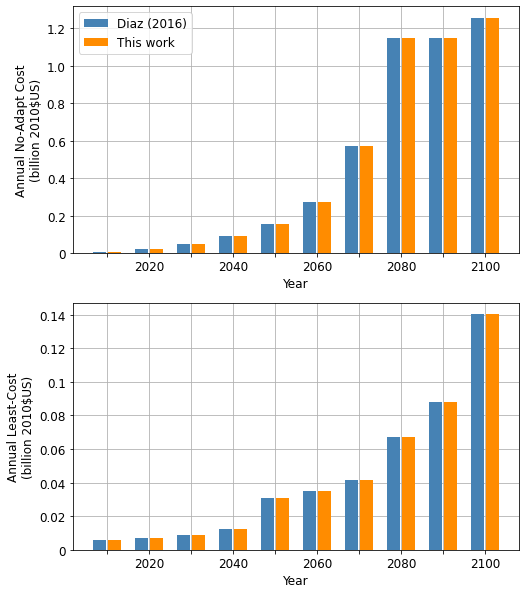

In [26]:
sep = 1.8
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(8,10))

ax[0].bar(x=dfDiaz.time-sep, height=dfDiaz.NoAdapt, width=3, color="steelblue", label="Diaz (2016)")
ax[0].bar(x=dfNew0.year+sep, height=dfNew0.NoAdapt, width=3, color="darkorange", label="This work")
ax[0].grid(); ax[0].set_axisbelow(True)

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]; ax[0].set_yticks(yticks); ax[0].set_yticklabels(yticks, fontsize=12)

ax[0].set_xticks(range(2010,2110,10)); ax[0].set_xticklabels(["",2020,"",2040,"",2060,"",2080,"",2100], fontsize=12)
ax[0].set_xlabel("Year", fontsize=12); ax[0].set_ylabel("Annual No-Adapt Cost\n(billion 2010$US)", fontsize=12)
ax[0].legend(fontsize=12)

ax[1].bar(x=dfDiaz.time-sep, height=dfDiaz.Optimal, width=3, color="steelblue", label="Diaz (2016)")
ax[1].bar(x=dfNew0.year+sep, height=dfNew0.Optimal, width=3, color="darkorange", label="This work")
ax[1].grid(); ax[1].set_axisbelow(True)

yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14]; ax[1].set_yticks(yticks); ax[1].set_yticklabels(yticks, fontsize=12)
ax[1].set_xticks(range(2010,2110,10)); ax[1].set_xticklabels(["",2020,"",2040,"",2060,"",2080,"",2100], fontsize=12)
ax[1].set_xlabel("Year", fontsize=12); ax[1].set_ylabel("Annual Least-Cost\n(billion 2010$US)", fontsize=12);

fig.savefig("baseline_comparison_rcp85.pdf", bbox_inches='tight');

#### total no-adaptation and optimal costs over time - version of figure with perfect foresight (matching GAMS version) and limited foresight

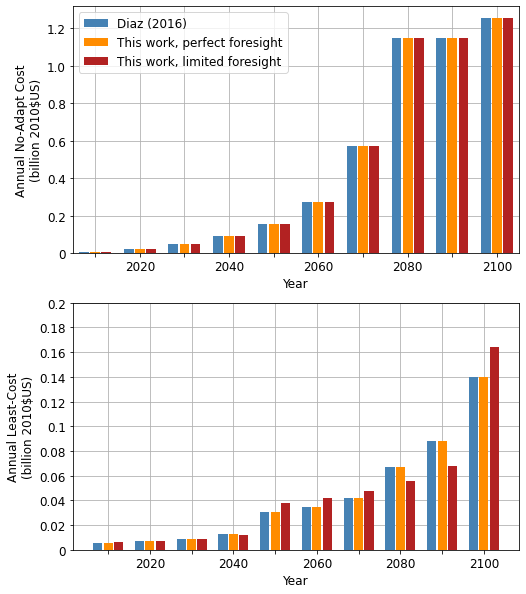

In [27]:
sep = 2.5
wid = 2.2

fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(8,10))

ax[0].bar(x=dfDiaz.time-sep, height=dfDiaz.NoAdapt, width=wid, color="steelblue", label="Diaz (2016)")
ax[0].bar(x=dfNew0.year, height=dfNew0.NoAdapt, width=wid, color="darkorange", label="This work, perfect foresight")
ax[0].bar(x=dfNew1.year+sep, height=dfNew1.NoAdapt, width=wid, color="firebrick", label="This work, limited foresight")
ax[0].grid(); ax[0].set_axisbelow(True); ax[0].set_xlim([2005,2105])

yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]; ax[0].set_yticks(yticks); ax[0].set_yticklabels(yticks, fontsize=12)

ax[0].set_xticks(range(2010,2110,10)); ax[0].set_xticklabels(["",2020,"",2040,"",2060,"",2080,"",2100], fontsize=12)
ax[0].set_xlabel("Year", fontsize=12); ax[0].set_ylabel("Annual No-Adapt Cost\n(billion 2010$US)", fontsize=12)
ax[0].legend(fontsize=12)

ax[1].bar(x=dfDiaz.time-sep, height=dfDiaz.Optimal, width=wid, color="steelblue", label="Diaz (2016)")
ax[1].bar(x=dfNew0.year, height=dfNew0.Optimal, width=wid, color="darkorange", label="This work")
ax[1].bar(x=dfNew1.year+sep, height=dfNew1.Optimal, width=wid, color="firebrick", label="This work, limited foresight")
ax[1].grid(); ax[1].set_axisbelow(True); ax[0].set_xlim([2005,2105])

yticks = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]; ax[1].set_yticks(yticks); ax[1].set_yticklabels(yticks, fontsize=12)

ax[1].set_xticks(range(2010,2110,10)); ax[1].set_xticklabels(["",2020,"",2040,"",2060,"",2080,"",2100], fontsize=12)
ax[1].set_xlabel("Year", fontsize=12); ax[1].set_ylabel("Annual Least-Cost\n(billion 2010$US)", fontsize=12);

fig.savefig("baseline_comparison_rcp85_withPerfectForesight.pdf", bbox_inches='tight');